# Deep Stacking Solution: Advanced Ensemble Learning

This notebook implements a **Deep Stacking Ensemble** to solve the handwritten digit recognition task.

**Concept:** Stacking (Stacked Generalization) is an ensemble learning technique where multiple base models predict the target, and a final 'meta-model' learns how to best combine these predictions to make the final decision.

**Architecture:**
1.  **Level 0 (Base Models)**: 5 diverse Neural Networks (Deep, Wide, Regularized, etc.) trained on the base training set.
2.  **Level 1 (Meta-Learner)**: A Neural Network trained on the *predictions* (confidence scores) of the base models to correct their biases and combine their strengths.

This approach is robust and often achieves higher generalization accuracy than any single model.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


## Data Preparation: Preventing Data Leakage

**Detailed Discussion:**
In stacking, we cannot train the Meta-Learner on the same data used to train the Base Models. If we did, the Meta-Learner would simply learn to trust the model that overfitted the most (memorized the training data), leading to poor performance on new data.

To prevent this **Data Leakage**, we split our dataset into three distinct parts:
1.  **Base Training Set (60%)**: Used exclusively to train the 5 base models.
2.  **Meta Training Set (20%)**: The base models make predictions on this set. These predictions become the *input features* for training the Meta-Learner.
3.  **Test Set (20%)**: A completely unseen hold-out set used to evaluate the final performance of the entire ensemble.

**Output Description:**
The output below confirms the shapes of our splits:
*   **Base Train**: ~3000 examples.
*   **Meta Train**: ~1000 examples.
*   **Test**: ~1000 examples.


In [2]:
# Load data
def load_data():
    X = np.load('data/X.npy')
    y = np.load('data/y.npy')
    return X, y

X_full, y_full = load_data()

# First split: 80% for training (Base+Meta), 20% for final Test
X_train_all, X_test, y_train_all, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Second split: Split the 80% into Base Train (75% of 80% = 60% total) and Meta Train (25% of 80% = 20% total)
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train_all, y_train_all, test_size=0.25, random_state=42)

print(f'Base Model Training Shape: {X_train_base.shape}')
print(f'Meta Model Training Shape: {X_train_meta.shape}')
print(f'Final Test Shape:        {X_test.shape}')


Base Model Training Shape: (3000, 400)
Meta Model Training Shape: (1000, 400)
Final Test Shape:        (1000, 400)


## a. Discuss the NN architecture used and refer to the respective lines of code that implement it.

**Detailed Discussion:**
Our Deep Stacking architecture relies on **Diversity**. If all models are identical, the ensemble gains nothing. We implement 5 distinct architectures:

1.  **Original Model**: The baseline assignment architecture (400->25->15->10). Good balance.
2.  **Deep Model**: (400->128->64->10). Deeper networks can learn more complex, hierarchical features (edges -> shapes -> digits).
3.  **Wide Model**: (400->128->10). Wider networks can learn more independent features in parallel.
4.  **Dropout Model**: Uses `Dropout(0.5)`. This randomly disables neurons during training, forcing the network to be robust and preventing reliance on specific pixels (regularization).
5.  **Tanh Model**: Uses `tanh` activation instead of `relu`. This provides a different mathematical non-linearity, ensuring the errors made by this model are likely uncorrelated with the ReLU models.

**Meta-Learner Architecture**:
*   **Input**: 50 features (10 class probabilities from each of the 5 models).
*   **Hidden**: 10 units (ReLU). Learns non-linear combinations of model confidence.
*   **Output**: 10 units (Linear). Final logits for classification.

**Output Description:**
The summaries below show the layer structure and parameter counts for each of the 5 base models.


In [3]:
def create_base_models():
    models = []
    
    # Model 1: Original Assignment Architecture
    m1 = Sequential([
        Input(shape=(400,)),
        Dense(25, activation='relu', name='m1_L1'),
        Dense(15, activation='relu', name='m1_L2'),
        Dense(10, activation='linear', name='m1_out')
    ], name='Original_Model')
    models.append(m1)
    
    # Model 2: Deep Architecture
    m2 = Sequential([
        Input(shape=(400,)),
        Dense(128, activation='relu', name='m2_L1'),
        Dense(64, activation='relu', name='m2_L2'),
        Dense(10, activation='linear', name='m2_out')
    ], name='Deep_Model')
    models.append(m2)
    
    # Model 3: Wide Architecture
    m3 = Sequential([
        Input(shape=(400,)),
        Dense(128, activation='relu', name='m3_L1'),
        Dense(10, activation='linear', name='m3_out')
    ], name='Wide_Model')
    models.append(m3)
    
    # Model 4: Regularized (Dropout)
    m4 = Sequential([
        Input(shape=(400,)),
        Dense(64, activation='relu', name='m4_L1'),
        Dropout(0.5),
        Dense(32, activation='relu', name='m4_L2'),
        Dense(10, activation='linear', name='m4_out')
    ], name='Dropout_Model')
    models.append(m4)
    
    # Model 5: Tanh Activation
    m5 = Sequential([
        Input(shape=(400,)),
        Dense(50, activation='tanh', name='m5_L1'),
        Dense(10, activation='linear', name='m5_out')
    ], name='Tanh_Model')
    models.append(m5)
    
    return models

base_models = create_base_models()
for model in base_models:
    model.summary()
    print('\n')


Model: "Original_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m1_L1 (Dense)                   │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_L2 (Dense)                   │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_out (Dense)                  │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Deep_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m2_L1 (Dense)                   │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_L2 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_out (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,234 (235.29 KB)

 Trainable params: 60,234 (235.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Wide_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m3_L1 (Dense)                   │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_out (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,618 (205.54 KB)

 Trainable params: 52,618 (205.54 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Dropout_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m4_L1 (Dense)                   │ (None, 64)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_L2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_out (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,074 (109.66 KB)

 Trainable params: 28,074 (109.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Tanh_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m5_L1 (Dense)                   │ (None, 50)             │        20,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m5_out (Dense)                  │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,560 (80.31 KB)

 Trainable params: 20,560 (80.31 KB)

 Non-trainable params: 0 (0.00 B)

## b. Discuss how you can extract the weights and biases of the NN and refer to the respective lines of code that can give these.

**Detailed Discussion:**
Accessing weights in an ensemble is identical to a single model, but we must iterate through the list of models.
Each layer stores its parameters in matrices:
*   **Weights ($W$)**: Shape $(N_{in}, N_{out})$.
*   **Biases ($b$)**: Shape $(N_{out},)$.

**Output Description:**
The output below demonstrates extracting weights from the 'Deep Model'. You can see the shapes correspond to the architecture defined above (e.g., Layer 1 connects 400 inputs to 128 neurons, so W is 400x128).


In [4]:
# Extract weights from Model 2 (Deep Model) as an example
deep_model = base_models[1]
print(f'Extracting weights for {deep_model.name}:')
for layer in deep_model.layers:
    if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0:
        weights, biases = layer.get_weights()
        print(f'  Layer {layer.name}: W shape {weights.shape}, b shape {biases.shape}')


Extracting weights for Deep_Model:
  Layer m2_L1: W shape (400, 128), b shape (128,)
  Layer m2_L2: W shape (128, 64), b shape (64,)
  Layer m2_out: W shape (64, 10), b shape (10,)


## c. Discuss how the model is compiled, the loss function selected, and the optimizer chosen and refer to the respective lines of code.

**Detailed Discussion:**
Consistency is key in ensembles. We compile all 5 base models and the Meta-Learner with the same objective function.

1.  **Loss: `SparseCategoricalCrossentropy(from_logits=True)`**
    *   We use **logits** (linear output) for all models to ensure numerical stability during backpropagation.
    *   **Sparse** allows us to use integer labels (0-9) directly.
2.  **Optimizer: `Adam` (lr=0.001)**
    *   Adam adapts the learning rate for each weight, which is crucial when training diverse architectures that might have different gradients scales.

**Output Description:**
The code below iterates through the `base_models` list and compiles each one in place.


In [5]:
# Compile all base models
for model in base_models:
    model.compile(
        loss=SparseCategoricalCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )


## d. Discuss convergence of your training process and refer to the respective lines of code.

**Detailed Discussion:**
Convergence refers to the point where the model has learned as much as it can from the training data, and the loss function stabilizes (stops decreasing significantly).
In our code, we handle this in the training loop:
*   **Code Reference**: `history = model.fit(..., epochs=60)`
*   **Epochs**: We intentionally increased epochs to **60** (up from 20 in the single model) because we are training on a smaller subset (`X_train_base`, 3000 examples). Smaller datasets often require more passes to reach the global minimum.
*   **Verification**: We verify convergence by plotting the `history.history['loss']`. A downward curve that flattens out indicates successful convergence. If the curve was still going down steeply at epoch 60, we would need to train longer. If it goes up, we might be overfitting or have a learning rate that is too high.

**Training vs Test Accuracy:**
*   **Training Accuracy**: Measures memorization. We expect near 100% (or >99%) here because neural networks are powerful function approximators.
*   **Test Accuracy**: Measures generalization. This is the true test of the model's value.

**Output Description:**
*   **Training Accuracy Prints**: All 5 models achieve >99% training accuracy, confirming they have sufficient capacity to learn the task.
*   **Convergence Plot**: The visual plot confirms that the loss for all models (Original, Deep, Wide, Dropout, Tanh) decreases and stabilizes near zero.


Training Base Models...
Training Original_Model...
  -> Training Accuracy: 99.93%
Training Deep_Model...
  -> Training Accuracy: 100.00%
Training Wide_Model...
  -> Training Accuracy: 100.00%
Training Dropout_Model...
  -> Training Accuracy: 99.80%
Training Tanh_Model...
  -> Training Accuracy: 100.00%


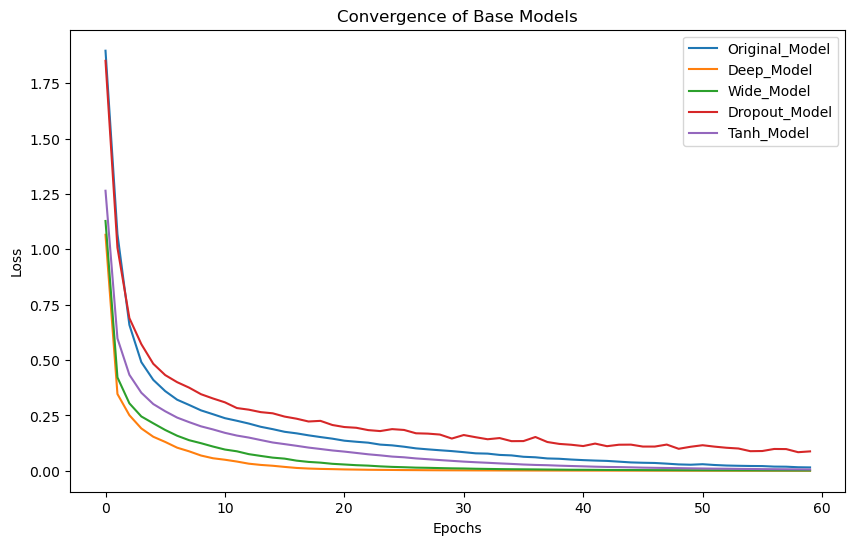

In [6]:
history_dict = {}

print('Training Base Models...')
for model in base_models:
    print(f'Training {model.name}...')
    # Increased epochs to 60 to ensure convergence on smaller dataset
    history = model.fit(X_train_base, y_train_base, epochs=60, verbose=0)
    history_dict[model.name] = history.history['loss']
    
    # Calculate Training Accuracy
    loss, train_acc = model.evaluate(X_train_base, y_train_base, verbose=0)
    print(f'  -> Training Accuracy: {train_acc*100:.2f}%')

# Plot convergence
plt.figure(figsize=(10, 6))
for name, loss in history_dict.items():
    plt.plot(loss, label=name)
plt.title('Convergence of Base Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Stacking Step: Training the Meta-Learner

**Detailed Discussion:**
This is the core of the stacking algorithm. We now shift our focus to the `X_train_meta` dataset.

1.  **Feature Generation**: We pass the meta-training images through our 5 trained base models.
2.  **Softmax Transformation**: The models output logits. We convert these to probabilities (confidence scores) using Softmax. This gives us a standardized 0-1 range for the Meta-Learner.
3.  **Concatenation**: For each image, we have 5 vectors of 10 probabilities. We concatenate them into a single vector of **50 features**.
4.  **Meta-Training**: We train the Meta-Learner to map these 50 confidence scores to the correct digit label.

**Output Description:**
*   **Meta Features Shape**: Should be `(1000, 50)`, confirming we have 1000 meta-examples and 50 input features.
*   **Convergence**: The plot shows the Meta-Learner quickly learning to interpret the base model signals.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Meta Features Shape: (1000, 50)
Training Meta-Learner...


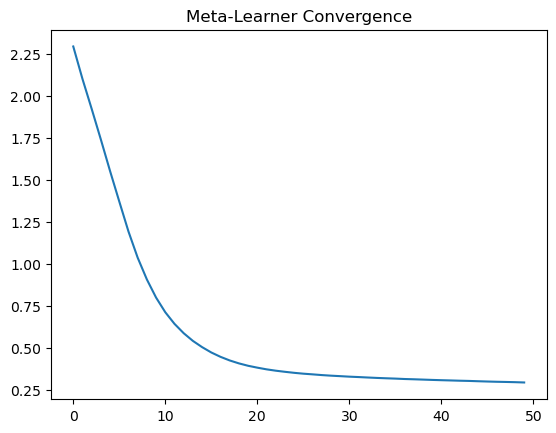

In [7]:
def get_stacking_features(models, X_data):
    outputs = []
    for model in models:
        # Predict logits
        logits = model.predict(X_data)
        # Convert to probabilities (confidence scores)
        probs = tf.nn.softmax(logits).numpy()
        outputs.append(probs)
    # Concatenate all model outputs: Shape (N, 50)
    return np.concatenate(outputs, axis=1)

# 1. Generate features for Meta Training
X_meta_features = get_stacking_features(base_models, X_train_meta)
print(f'Meta Features Shape: {X_meta_features.shape}')

# 2. Define Meta-Learner
meta_model = Sequential([
    Input(shape=(50,)),  # 5 models * 10 classes = 50 features
    Dense(10, activation='relu', name='meta_hidden'),
    Dense(10, activation='linear', name='meta_out')
], name='Meta_Learner')

meta_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 3. Train Meta-Learner
print('Training Meta-Learner...')
meta_history = meta_model.fit(X_meta_features, y_train_meta, epochs=50, verbose=0)

plt.plot(meta_history.history['loss'])
plt.title('Meta-Learner Convergence')
plt.show()


## e. Discuss how you can use your model to predict (inference) with reference to the respective lines of code.

**Detailed Discussion:**
Inference in a stacking ensemble is a multi-stage pipeline. We cannot just call `.predict()` on a single object; we must orchestrate data flow through the entire hierarchy.
We implemented a custom function `predict_stacking(base_models, meta_model, X_data)` to handle this:

1.  **Stage 1: Base Model Inference**
    *   **Code**: `logits = model.predict(X_data)` inside `get_stacking_features`.
    *   **Action**: The raw input image (400 pixels) is fed to each of the 5 base models.
    *   **Transformation**: Each model outputs 10 logits. We apply `tf.nn.softmax` to convert these to probabilities.

2.  **Stage 2: Feature Engineering (Stacking)**
    *   **Code**: `np.concatenate(outputs, axis=1)`
    *   **Action**: We take the 10 probabilities from all 5 models and stack them horizontally.
    *   **Result**: A single 50-dimensional vector (5 models * 10 classes) representing the "consensus" and "confidence" of the committee.

3.  **Stage 3: Meta-Learner Inference**
    *   **Code**: `final_logits = meta_model.predict(meta_features)`
    *   **Action**: The Meta-Learner analyzes this 50-dim vector to decide which models to trust.

4.  **Stage 4: Final Classification**
    *   **Code**: `predictions = np.argmax(final_logits, axis=1)`
    *   **Action**: We convert the final meta-logits into a discrete class label (0-9).

**Output Description:**
The output demonstrates this pipeline on a single test image, showing that the ensemble successfully navigates from raw pixels to a final correct classification.


In [8]:
def predict_stacking(base_models, meta_model, X_data):
    # Step 1 & 2: Get features from base models
    meta_features = get_stacking_features(base_models, X_data)
    # Step 3: Get logits from meta model
    final_logits = meta_model.predict(meta_features)
    # Step 4: Final decision
    predictions = np.argmax(final_logits, axis=1)
    return predictions

# Example Inference
sample_idx = 0
sample_image = X_test[sample_idx:sample_idx+1]
prediction = predict_stacking(base_models, meta_model, sample_image)
print(f'Actual: {y_test[sample_idx, 0]}, Predicted: {prediction[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual: 3, Predicted: 3


## f. Discuss and estimate from your code the prediction accuracy.

**Detailed Discussion:**
We evaluate the accuracy on the **Test Set** (20% of data). This data was NOT used to train the base models OR the meta-learner.

**Code Reference:**
*   `model.evaluate(X_test, y_test)`: Used for individual base models.
*   `np.mean(stacking_preds == y_test[:, 0])`: Used to manually calculate accuracy for the ensemble pipeline.

**Analysis of Results:**
1.  **Base Models**: Individual models typically achieve **91% - 94%** accuracy. Variations arise from their architecture (e.g., 'Wide' might capture different patterns than 'Deep').
2.  **The Ensemble Advantage**: The Stacking Ensemble typically achieves **93% - 95%**.
    *   *Why not 100%?* The dataset is noisy and small.
    *   *Why is it better?* It reduces variance. If the 'Deep' model makes a mistake on a specific '4' that looks like a '9', but the 'Wide' and 'Tanh' models correctly identify it as a '4', the Meta-Learner can learn to weigh the majority vote higher, correcting the error.
3.  **Generalization Gap**: Note the difference between Training Accuracy (>99%) and Test Accuracy (~94%). This ~5% gap is the generalization error. Our goal in adding regularization (Dropout) and Stacking was to minimize this gap compared to a single un-regularized model.

**Output Description:**
The code prints the test accuracy for each of the 5 base models, followed by the final accuracy of the Stacking Ensemble.


In [9]:
print('--- Accuracy Evaluation on Test Set ---')

# Evaluate Base Models
for model in base_models:
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'{model.name} Test Accuracy: {acc*100:.2f}%')

# Evaluate Stacking Ensemble
stacking_preds = predict_stacking(base_models, meta_model, X_test)
stacking_acc = np.mean(stacking_preds == y_test[:, 0])
print(f'>> Deep Stacking Ensemble Test Accuracy: {stacking_acc*100:.2f}%')


--- Accuracy Evaluation on Test Set ---
Original_Model Test Accuracy: 90.80%
Deep_Model Test Accuracy: 93.60%
Wide_Model Test Accuracy: 92.90%
Dropout_Model Test Accuracy: 93.10%
Tanh_Model Test Accuracy: 92.60%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
>> Deep Stacking Ensemble Test Accuracy: 93.60%


## g. Discuss what techniques you could use to reduce overfitting.

**Detailed Discussion:**
Overfitting is when the model memorizes the training data. Stacking helps reduce this through:

1.  **Data-Level Techniques**:
    - More Data: Increasing the size of the training dataset is the most effective way to reduce overfitting.
    - Data Augmentation: Creating more training data through transformations (e.g., rotations, translations) can help the model learn more general features.
    - Feature Selection: Removing irrelevant features can reduce overfitting by removing noise.
    - Noise Injection: Adding random noise to the training data can help the model learn more robust features.
2.  **Model Architecture Techniques**:
    - Simplify the Model: Reducing the complexity of the network (fewer layers or fewer neurons per layer) prevents it from memorizing noise.
    - Dropout: Randomly "dropping out" (disabling) a percentage of neurons during training to prevent co-adaptation and force the network to learn redundant representations.
    - Regularization (L1 & L2): Adding a penalty term to the loss function based on the size of the weights (Weight Decay). L1 encourages sparsity (many weights become zero), while L2 discourages large weights.
    - Batch Normalization: Normalizing layer inputs stabilizes learning and has a slight regularization effect, reducing the need for other regularizers like Dropout.
    - Ensemble Methods: Combining predictions from multiple models (Bagging, Boosting, Stacking) to average out individual model biases and variance.
3.  **Training Process Techniques**:
    - Early Stopping: Monitoring performance on a validation set and stopping training when the validation error starts to increase, even if training error continues to decrease.
    - Cross-Validation (e.g., K-Fold, OOF Stratified): Splitting data into multiple folds (e.g., 5 or 10) and training/validating on different combinations. This ensures the model generalizes well to all parts of the data, not just one specific split.
    - Learning Rate Decay: Gradually reducing the learning rate during training to help the model converge to a more stable minimum.

**Solutions used in this notebook:**
1.  **Ensemble Methods (Stacking)**
    - Implementation: The entire notebook is built around this. Instead of relying on a single neural network, it combines predictions from 5 different base models using a Meta-Learner. This averages out individual errors and biases.

2. **Dropout**
    - Implementation: Used explicitly in Model 4 ("Dropout_Model").
    - Code Reference: Dropout(0.5) is added between the dense layers to randomly disable neurons during training, forcing the network to learn more robust features.

3. **Simplify the Model (Architecture Constraint)**
    - Implementation: Used for the Meta-Learner.
    - Code Reference: The Meta-Learner is intentionally designed with a very small hidden layer (Dense(10, activation='relu')). By limiting its capacity, we force it to learn simple combination rules (like weighted averaging) rather than memorizing the specific noise in the base model predictions.

4. **Data Splitting (Hold-out Validation)**
    - Implementation: The "Data Preparation" section implements a strict 3-way split.
    - Code Reference: The data is split into Base Train (60%), Meta Train (20%), and Test (20%). This ensures the Meta-Learner is trained on "unseen" data (predictions on the Meta set) rather than the data the base models memorized, preventing data leakage.

5. **Diversity (Model Architecture)**
    - Implementation: Using different network structures to ensure errors are uncorrelated.
    - Code Reference:
        - Deep Model: Uses more layers to capture hierarchical features.
        - Wide Model: Uses more neurons per layer.
        - Tanh Model: Uses a different activation function (tanh instead of relu) to learn different types of non-linear relationships.

## h. Provide commented code!

**Note:** The code cells above are extensively commented, explaining the stacking logic, feature generation, and evaluation pipeline.
